# Supervised Machine Learning

The below code contains the SVM model and Logistic Regression model for the 3 year slice of time.

## Imports

These are the imports needed to fun this code. If anything is not allows to import, please !pip install accordingly.

In [1]:
# Import required libraries
import pandas as pd
from pathlib import Path
from pandas.tseries.offsets import DateOffset
import warnings
warnings.filterwarnings("ignore")
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

## Load Pre Processed data for 1 year Period

In [2]:
# Read
trading_df = pd.read_csv(
    Path('../../Data/ETF CSV files/Cost_and_volume_3yr.csv'), 
    index_col="time", 
    infer_datetime_format=True, 
    parse_dates=True)

# Review the Data-Frame
trading_df.head()

,Asia_50_Volume,Core_MSCI_World_ex_Australia_ESG_Leaders_Volume,Edge_MSCI_World_Multifactor_Volume,Global_100_Volume,Global_Consumer_Staples_Volume,Global_Healthcare_Volume,SP_500_Volume,volume,Asia_50_Costs,Core_MSCI_World_ex_Australia_ESG_Leaders_Costs,Edge_MSCI_World_Multifactor_Costs,Global_Consumer_Staples_Costs,Global_Healthcare_Costs,SP_500_Costs,Global_100_Costs,close
time,,,,,,,,,,,,,,,,
2019-06-30,"5,874,547.00","2,283,466.00","6,524,648.00","23,002,661.00","2,430,031.00","6,602,958.00","7,360,698.00","7,725,572.71",87.90,35.65,32.80,75.74,88.54,422.20,71.27,116.300000
2019-07-01,"5,877,002.00","2,326,207.00","6,526,265.00","23,017,968.00","2,433,221.00","6,605,878.00","7,363,285.00","7,735,689.43",89.14,35.55,32.85,75.68,88.94,426.69,70.87,117.102857
2019-07-02,"5,888,602.00","2,326,207.00","6,526,265.00","23,017,968.00","2,433,221.00","6,605,878.00","7,350,285.00","7,735,489.43",88.49,35.50,32.75,76.09,89.00,426.25,70.72,116.971429
2019-07-03,"5,888,602.00","2,326,207.00","6,526,265.00","23,033,968.00","2,434,721.00","6,611,078.00","7,354,185.00","7,739,289.43",87.59,35.57,32.84,76.55,89.27,427.23,70.51,117.080000
2019-07-04,"5,893,313.00","2,326,091.00","6,525,749.00","23,050,546.00","2,431,848.00","6,611,789.00","7,352,942.00","7,741,754.00",87.75,35.64,32.91,76.69,89.43,428.00,70.25,117.238571


## Data Preparation

In [3]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df["close"].pct_change()

# Define a window size of 4
short_window = 4

# Create a simple moving average (SMA) using the short_window and assign this to a new columns called sma_fast
trading_df["sma_fast"] = trading_df["close"].rolling(window=short_window).mean()

# Define a window size of 100
long_window = 100

# Create a simple moving average (SMA) using the long_window and assign this to a new columns called sma_slow
trading_df["sma_slow"] = trading_df["close"].rolling(window=long_window).mean()

# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
X = trading_df[["sma_fast", "sma_slow"]].copy()

# Create a new column in the trading_df called signal setting its value to zero.
trading_df["signal"] = 0.0

# Create the signal to buy
trading_df.loc[(trading_df["actual_returns"] >= 0), "signal"] = 1

# Create the signal to sell
trading_df.loc[(trading_df["actual_returns"] < 0), "signal"] = -1

# Copy the new signal column to a new Series called y.
y = trading_df["signal"].copy()

## Splitting the features and values

In [4]:
# Select the start of the training period
training_begin =  X.index.min()

# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)
X.index.min() + DateOffset(months=3)

# Create the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Create the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## SVM Model

In [5]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [6]:
# Evaluate the model using a classification report
svm_training_report = classification_report(y_train, training_signal_predictions)

# Print the classification report for the SVM model using the training data
print("SVM Classification Report (training data)")
print(svm_training_report)

SVM Classification Report (training data)
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        23
         1.0       0.63      1.00      0.78        40

    accuracy                           0.63        63
   macro avg       0.32      0.50      0.39        63
weighted avg       0.40      0.63      0.49        63



In [7]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [8]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)

# Print the classification report for the SVM model using the test data
print("SVM Classification Report (test data)")
print(svm_testing_report)

SVM Classification Report (test data)
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       284
         1.0       0.53      1.00      0.69       318

    accuracy                           0.53       602
   macro avg       0.26      0.50      0.35       602
weighted avg       0.28      0.53      0.37       602



## Logistic Regression Model

In [9]:
# Create an instance of the LogisticRegression model
logistic_regression_model = LogisticRegression()

# Fit the LogisticRegression model
logistic_regression_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [10]:
# Use the trained LogisticRegression model to predict the trading signals for the training data
lr_training_signal_predictions = logistic_regression_model.predict(X_train_scaled)

# Display the predictions
lr_training_signal_predictions

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [11]:
# Generate a classification report using the training data and the logistic regression model's predications
lr_training_report = classification_report(y_train, lr_training_signal_predictions)

# Use the trained model to predict the trading signals for the testing data.
lr_testing_signal_predictions = logistic_regression_model.predict(X_test_scaled)

# Generate a classification report using the testing data and the logistic regression model's predictions
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

In [12]:
# Print the classification report for the Logistic Regression model using training data
print("Logistic Regression Classification Report (Training data)")
print(lr_training_report)

Logistic Regression Classification Report (Training data)
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        23
         1.0       0.63      1.00      0.78        40

    accuracy                           0.63        63
   macro avg       0.32      0.50      0.39        63
weighted avg       0.40      0.63      0.49        63



In [13]:
# Print the classification report for the Logistic Regression model using the test data
print("Logistic Regression Classification Report (Test data)")
print(lr_testing_report)

Logistic Regression Classification Report (Test data)
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       284
         1.0       0.53      1.00      0.69       318

    accuracy                           0.53       602
   macro avg       0.26      0.50      0.35       602
weighted avg       0.28      0.53      0.37       602



## Plots

In [14]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["predicted_signal"] = testing_signal_predictions
predictions_df["actual_returns"] = trading_df["actual_returns"]
predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
time,,,
2020-02-14,1.0,0.003849,0.003849
2020-02-17,1.0,-0.003424,-0.003424
2020-02-18,1.0,-0.000021,-0.000021
2020-02-19,1.0,0.010476,0.010476
2020-02-20,1.0,-0.002427,-0.002427


<AxesSubplot:title={'center':'Cumulative Returns for [Actual Returns] vs [Trading Algorithm Returns] (3 year)'}, xlabel='time'>

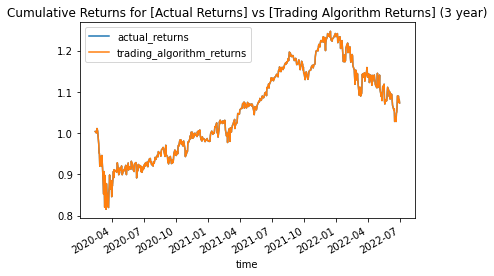

In [15]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot(title = "Cumulative Returns for [Actual Returns] vs [Trading Algorithm Returns] (3 year)")